In [ ]:
import cv2
import math

In [160]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

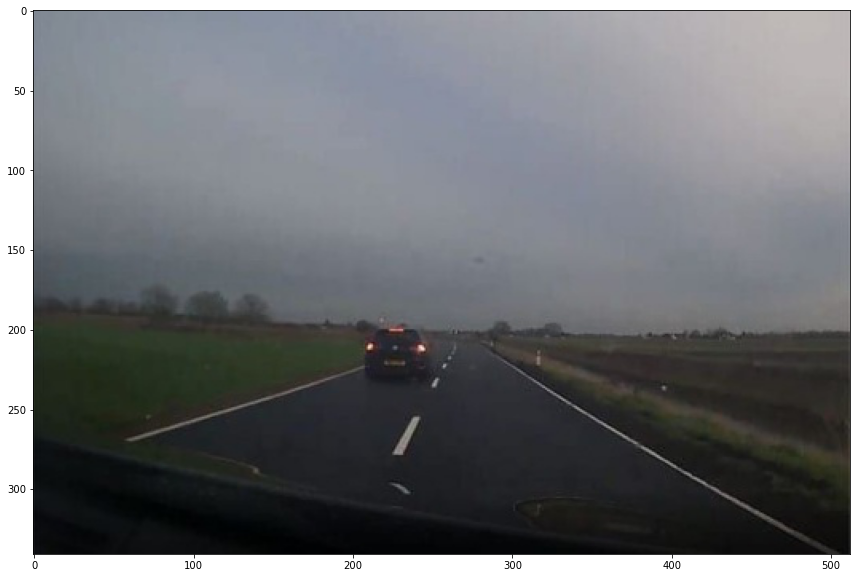

In [161]:
img = cv2.imread('data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

(<AxesSubplot:title={'center':'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

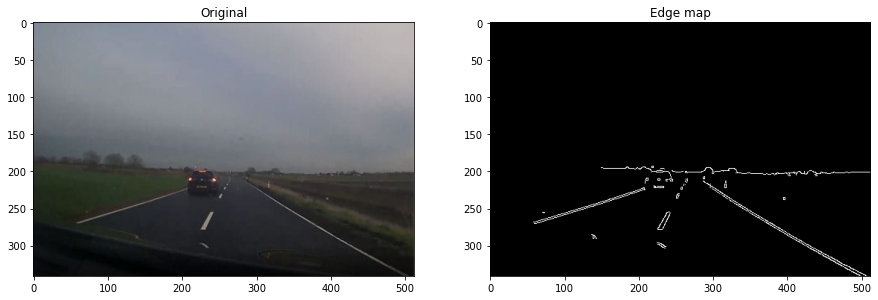

In [162]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

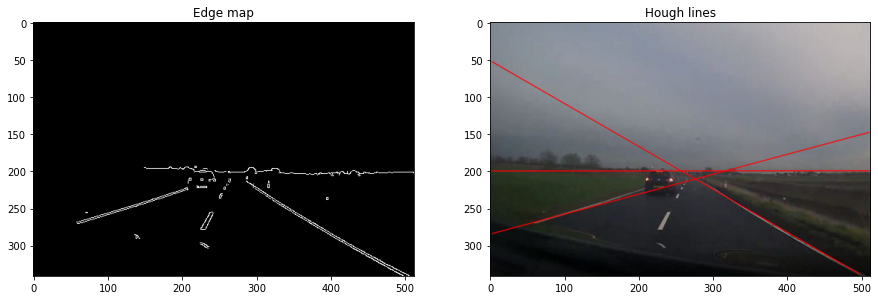

In [155]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 5 pixels and slope resolution of 5 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 90
 
lines = cv2.HoughLines(edges, rho=5, theta=5*np.pi/180, threshold=90)

# Let's get rid of the unnecessary dimension
#lines = lines[:, 0, :]

#Пайтон новый для меня язык, не разобрался до конца со списками. 
#Данная конcтрукция не сработала

# Plot the resulting Hough lines
result = np.copy(img)
        
for line in range(0, len(lines[0:3])):
    rho = lines[line][0][0]
    theta = lines[line][0][1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [153]:
# НЕ МОГУ ПОНЯТЬ, почему не определяется средняя линия.
# Только при theta=30*np.pi/180, но тогда пропадают левая и горизонтальная

# Также не разобрался по какой причине определяются только по одной линии,
# пробовал играть с параметрами, результат всегда такой. Пучок линий не определяется.

In [163]:
# Filter out all lines that are approximately horizontal (+/- 15 degrees). 
filtered_lines = []
for line in range(0, len(lines[0:3])):
    # Extract theta for current line (remember Hough works with radians)
    theta = lines[line][0][1]
    theta = theta*180/np.pi
    # Keep line if theta is not horizontal
    if theta > 105 or theta < 75:
        filtered_lines.append(line)

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

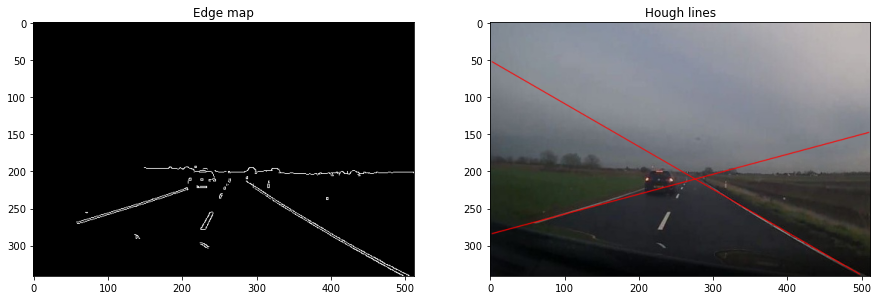

In [164]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = lines[line][0][0]
    theta = lines[line][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [165]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(filtered_lines)
kmeans.cluster_centers_



ValueError: Expected 2D array, got 1D array instead:
array=[0. 2.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# Последняя ошибка вообще выше моего понимания, но подозреваю, что связана она с отсутствием множества найденных линий

# Ответы на вопросы
# 1) Наибольшая странность - то что я каким-то образом сразу получил искомый результат без кластеризации.
# 2) При больших значениях rho получаем непарралельность обнаруженных линий относительно изображённых на исходном 
#    изображении. 
#    При разных theta определялись разные линии. В данном примере средняя линия нашлась при theta=30, но пропали левая и горизонтальная. 
# 3) Treshold сильно зависит от длины линии, которую необходимо обнаружить. Если нужны отдельные короткие отрезки,
#    то при больших значениях параметра, они не будут обнаружены.